In [ ]:
%pip install pandas numpy seaborn matplotlib scikit-learn xgboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import pickle as pkl

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import StandardScaler as StdScaler
# import hyperopt

from models import decision_tree, k_nearest, logistic_regression, random_forest, support_vector_cls, xgboost

In [2]:
csv_file_names = ["pyradiomics_extraction_box_with_correct_mask.csv", "pyradiomics_extraction_box_without_correct_mask.csv", 
             "pyradiomics_extraction_segmentation_maskcorrect.csv", "pyradiomics_extraction_segmentation_no_maskcorrect.csv"]

FILE_INDEX = 2
FILENAME = csv_file_names[FILE_INDEX].split('.')[0] +  '_with_preprocessing'
RESULTS_PATH = f'Results_DemoGraphics/{FILENAME}.csv'

CLASS_LABELS = '../../Data/Patient class labels.csv'
DF_PATH = '../../Data/Without Demographic Features/' + csv_file_names[FILE_INDEX]
MODEL_PICKLING = f'Results_DemoGraphics/{FILENAME}.pkl'

In [3]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.15
TEST_RATIO = 0.25

SEED = 2454259

CRITERION = 'accuracy'

In [4]:
labels = pd.read_csv(CLASS_LABELS)
features = pd.read_csv(DF_PATH).drop(columns = 'sequence', errors='ignore')
total_features = pd.merge(features, labels, left_on = 'patient', right_on = 'Patient ID').drop(columns = ['Patient ID', 'patient'])
total_features

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ER,PR,HER2,Mol Subtype
0,0.807005,0.729780,23.614309,32.358102,36.073737,38.431136,39.309346,45.798426,11352.720347,26.113156,...,4.009263e+06,0.0,1000000.0,0.0,0.0,0.0,0,0,1,2
1,0.641558,0.577887,17.378564,30.072592,23.148662,29.852205,29.748492,33.784677,4051.005400,19.293327,...,6.054147e+06,0.0,1000000.0,0.0,0.0,0.0,0,0,0,3
2,0.756223,0.272616,13.050754,47.872295,40.488107,43.126056,56.606869,57.665740,11866.396187,36.202150,...,1.663605e+07,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
3,0.718139,0.610317,8.730117,14.304230,11.420813,14.972284,14.477716,16.540987,829.333325,10.272429,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
4,0.687760,0.436019,22.539193,51.693090,55.175581,49.674566,36.443449,58.274413,25572.814941,35.552459,...,4.436710e+08,0.0,1000000.0,0.0,0.0,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.886914,0.668151,28.553043,42.734408,45.886501,41.977361,51.383808,56.016573,28567.316541,37.901723,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
918,0.757419,0.596730,12.864613,21.558522,21.066007,20.543932,25.375225,27.268354,2558.161146,16.328835,...,4.485585e+06,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
919,0.872632,0.837806,15.199560,18.142097,19.038279,20.649190,20.505122,24.348411,2671.696974,15.831368,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
920,0.855874,0.735409,30.453436,41.410193,43.076382,45.448460,48.143552,54.398662,28568.303573,35.441921,...,1.504081e+08,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0


## Train test split

In [23]:
def train_test_val_splits(df, train_ratio = 0.8, val_ratio = 0.2, random_state = 2454259):
   
    val_ratio_adj = val_ratio / (1-train_ratio)

    train_df, val_df = train_test_split(df, train_size = train_ratio, random_state= random_state)
    val_df, test_df = train_test_split(val_df, train_size = val_ratio_adj, random_state= random_state)

    return train_df, val_df, test_df

train_df, val_df, test_df = train_test_val_splits(total_features, TRAIN_RATIO, VAL_RATIO, random_state = SEED)

Feature scaling - on all three datasets;    
Feature Engineering - on training+validation only;      
Resampling - on training only

In [24]:
train_x = train_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
train_y_er = train_df['ER'].to_numpy()
train_y_pr = train_df['PR'].to_numpy()
train_y_her2 = train_df['HER2'].to_numpy()
train_y_mol_subtype = train_df['Mol Subtype'].to_numpy()


val_x = val_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
val_y_er = val_df['ER'].to_numpy()
val_y_pr = val_df['PR'].to_numpy()
val_y_her2 = val_df['HER2'].to_numpy()
val_y_mol_subtype = val_df['Mol Subtype'].to_numpy()

test_x = test_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
test_y_er = test_df['ER'].to_numpy()
test_y_pr = test_df['PR'].to_numpy()
test_y_her2 = test_df['HER2'].to_numpy()
test_y_mol_subtype = test_df['Mol Subtype'].to_numpy()

scaler = Scaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)
print('Features scaled')

Features scaled


In [25]:
train_x_er, train_x_pr, train_x_her2, train_x_mol_subtype = train_x.copy(), train_x.copy(), train_x.copy(), train_x.copy()
val_x_er, val_x_pr, val_x_her2, val_x_mol_subtype = val_x.copy(), val_x.copy(), val_x.copy(), val_x.copy()
test_x_er, test_x_pr, test_x_her2, test_x_mol_subtype = test_x.copy(), test_x.copy(), test_x.copy(), test_x.copy()

## Resampling

### Imbalanced Data

In [20]:
# # splitting the dataset for training, testing, validating on ER subtype
# train_x_er, train_y_er = train_df.drop(columns = ['ER']), train_df['ER']
# val_x_er, val_y_er = val_df.drop(columns = ['ER']), val_df['ER']
# test_x_er, test_y_er = test_df.drop(columns = ['ER']), test_df['ER']

# # splitting the dataset for training, testing, validating on PR subtyp
# train_x_pr, train_y_pr = train_df.drop(columns = ['PR']), train_df['PR']
# val_x_pr, val_y_pr = val_df.drop(columns = ['PR']), val_df['PR']
# test_x_pr, test_y_pr = test_df.drop(columns = ['PR']), test_df['PR']

# # splitting the dataset for training, testing, validating on HER2 subtype
# train_x_her2, train_y_her2 = train_df.drop(columns = ['HER2']), train_df['HER2']
# val_x_her2, val_y_her2 = val_df.drop(columns = ['HER2']), val_df['HER2']
# test_x_her2, test_y_her2 = test_df.drop(columns = ['HER2']), test_df['HER2']

# # splitting the dataset for training, testing, validating on molecular subtype
# train_x_mol_subtype, train_y_mol_subtype = train_df.drop(columns = ['Mol Subtype']), train_df['Mol Subtype']
# val_x_mol_subtype, val_y_mol_subtype = val_df.drop(columns = ['Mol Subtype']), val_df['Mol Subtype']
# test_x_mol_subtype, test_y_mol_subtype = test_df.drop(columns = ['Mol Subtype']), test_df['Mol Subtype']

KeyError: "['Mol Subtype'] not found in axis"

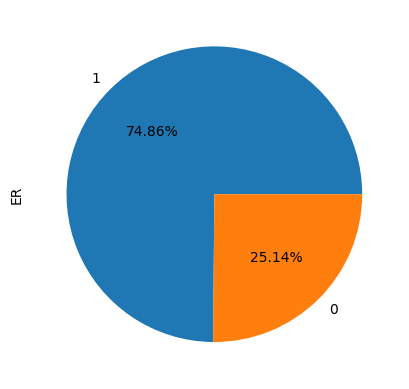

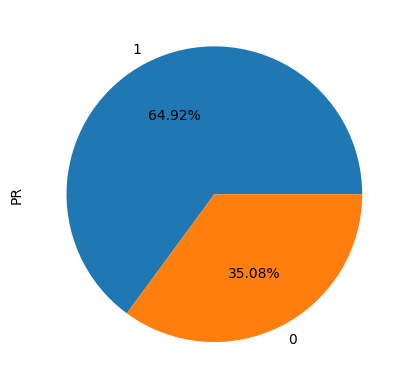

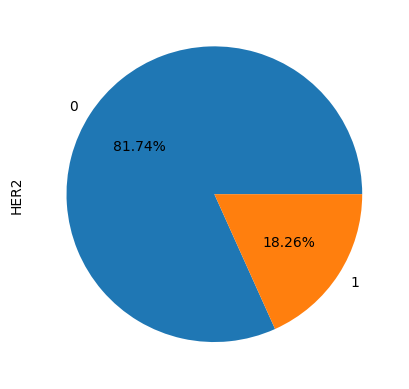

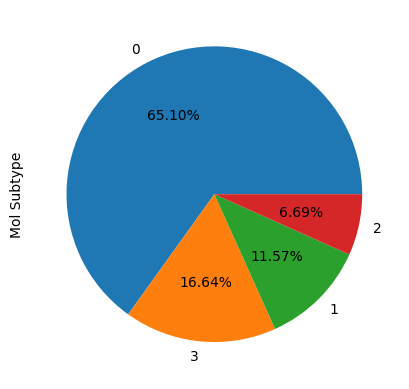

In [26]:
train_df['ER'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['PR'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['HER2'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['Mol Subtype'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [27]:
print("Train:", len(train_x_er), ", Val:", len(val_x_er), ", Test:", len(test_x_er))
dist = pd.DataFrame({'ER+': [train_y_er.value_counts()[0], val_y_er.value_counts()[0], test_y_er.value_counts()[0]],
                     'ER-': [train_y_er.value_counts()[1], val_y_er.value_counts()[1], test_y_er.value_counts()[1]],
                     'PR+': [train_y_pr.value_counts()[0], val_y_pr.value_counts()[0], test_y_pr.value_counts()[0]],
                     'PR-': [train_y_pr.value_counts()[1], val_y_pr.value_counts()[1], test_y_pr.value_counts()[1]],
                     'HER2+': [train_y_her2.value_counts()[0], val_y_her2.value_counts()[0], test_y_her2.value_counts()[0]],
                     'HER2-': [train_y_her2.value_counts()[1], val_y_her2.value_counts()[1], test_y_her2.value_counts()[1]],
                     'Mol Subtype (0)': [train_y_mol_subtype.value_counts()[0], val_y_mol_subtype.value_counts()[0], test_y_mol_subtype.value_counts()[0]],
                     'Mol Subtype (1)': [train_y_mol_subtype.value_counts()[1], val_y_mol_subtype.value_counts()[1], test_y_mol_subtype.value_counts()[1]],
                     'Mol Subtype (2)': [train_y_mol_subtype.value_counts()[2], val_y_mol_subtype.value_counts()[2], test_y_mol_subtype.value_counts()[2]],
                     'Mol Subtype (3)': [train_y_mol_subtype.value_counts()[3], val_y_mol_subtype.value_counts()[3], test_y_mol_subtype.value_counts()[3]]},
                     index = ['Train', 'Val', 'Test'])
dist

Train: 553 , Val: 138 , Test: 231


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [ ]:
# # creating multiple subplots of graph to visualise the above data 
# fig, axes = plt.subplots(4, 3, figsize=(20, 15))
# plot_data = [[train_y_er, val_y_er, test_y_er], [train_y_pr, val_y_pr, test_y_pr], [train_y_her2, val_y_her2, test_y_her2], [train_y_mol_subtype, val_y_mol_subtype, test_y_mol_subtype]]
# for i in range(4):
#     for j in range(3):
#         sns.countplot(x=plot_data[i][j], ax=axes[i][j])
#         if i == 0:
#             axes[i][j].set_xlabel('ER Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: ER Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: ER Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: ER Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 1:
#             axes[i][j].set_xlabel('PR Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: PR Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: PR Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: PR Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 2:
#             axes[i][j].set_xlabel('HER2 Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: HER2 Distribution (0 = Negative, 1 = Positive)')
        
#         else:
#             axes[i][j].set_xlabel('Molecular Subtype')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: Molecular Subtype Distribution')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: Molecular Subtype Distribution')
#             else:
#                 axes[i][j].set_title('Testing Data: Molecular Subtype Distribution')

#         axes[i][j].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

### Resampling for Training Samples

In [27]:
# Resampling the training data to balance the dataset using SMOTE

from imblearn.over_sampling import SMOTE

def resample_data_smote(x, y):
    sm = SMOTE(random_state = SEED)
    x_res, y_res = sm.fit_resample(x, y)
    return x_res, y_res

train_x_er_sam, train_y_er_sam = resample_data_smote(train_x_er, train_y_er)
# train_x_pr_sam, train_y_pr_sam = resample_data_smote(train_x_pr, train_y_pr)
train_x_her2_sam, train_y_her2_sam = resample_data_smote(train_x_her2, train_y_her2)
# train_x_mol_subtype_sam, train_y_mol_subtype_sam = resample_data_smote(train_x_mol_subtype, train_y_mol_subtype)

In [28]:
train_x_er = train_x_er_sam.copy()
train_y_er = train_y_er_sam.copy()

# train_x_pr = train_x_pr_sam.copy()
# train_y_pr = train_y_pr_sam.copy()

train_x_her2 = train_x_her2_sam.copy()
train_y_her2 = train_y_her2_sam.copy()

# train_x_mol_subtype = train_x_mol_subtype_sam.copy()
# train_y_mol_subtype = train_y_mol_subtype_sam.copy()

print(train_x_er.shape, train_y_er.shape)
print(train_x_pr.shape, train_y_pr.shape)
print(train_x_her2.shape, train_y_her2.shape)
print(train_x_mol_subtype.shape, train_y_mol_subtype.shape)

(828, 107) (828,)
(553, 107) (553,)
(904, 107) (904,)
(553, 107) (553,)


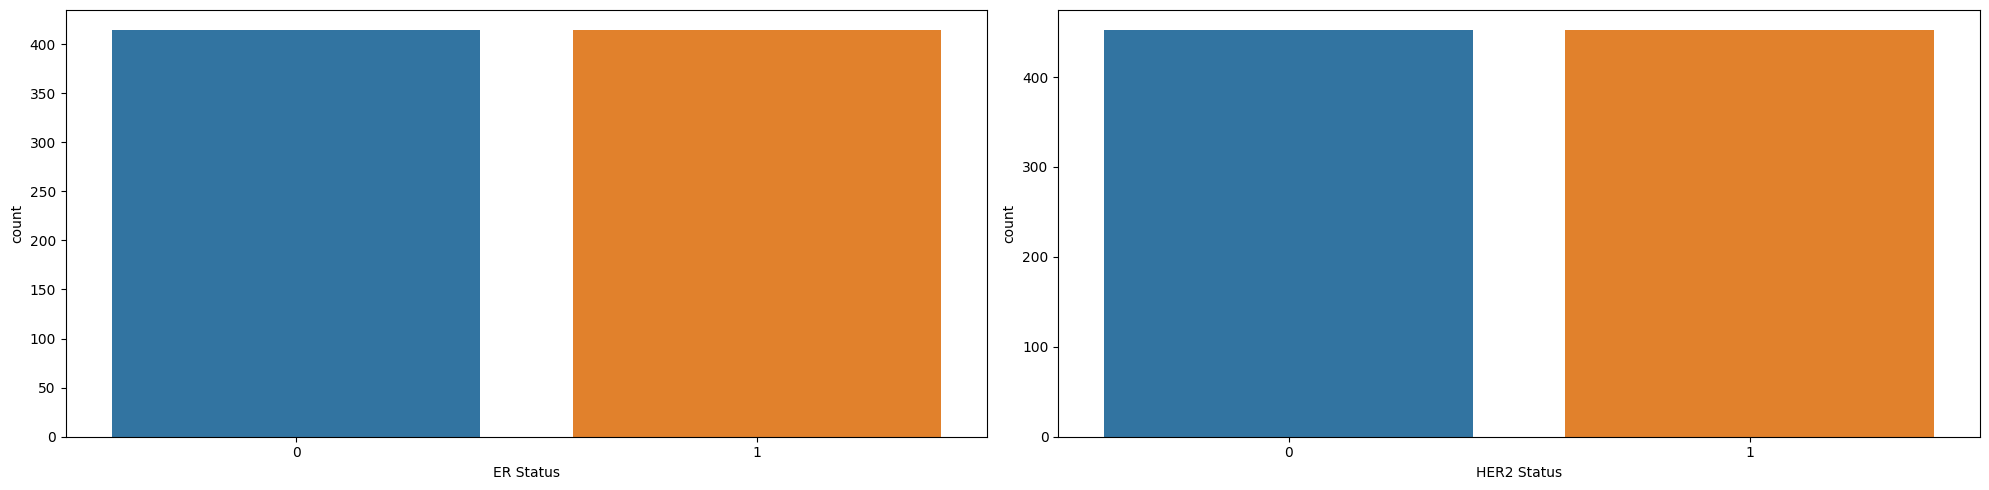

In [29]:
# Plotting the distribution of the resampled data

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=train_y_er, ax=axes[0])
axes[0].set_xlabel('ER Status')

sns.countplot(x=train_y_her2, ax=axes[1])
axes[1].set_xlabel('HER2 Status')

plt.tight_layout()
plt.show()

## Fitting models

In [30]:
classifications_classes = {
    'ER' : (train_x_er, train_y_er, val_x_er, val_y_er, test_x_er, test_y_er),
    'PR' : (train_x_pr, train_y_pr, val_x_pr, val_y_pr, test_x_pr, test_y_pr),
    'HER2': (train_x_her2, train_y_her2, val_x_her2, val_y_her2, test_x_her2, test_y_her2),
    'Mol Subtype': (train_x_mol_subtype, train_y_mol_subtype, val_x_mol_subtype, val_y_mol_subtype, test_x_mol_subtype, test_y_mol_subtype)
}

In [31]:
def get_metrics(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}


In [32]:
def get_NB_model(tx, ty, vx, vy, testx, testy, classification = None):
    nb = GaussianNB()
    nb.fit(tx, ty)
    
    train_metrics = get_metrics(nb, tx, ty, 'train')
    val_metrics = get_metrics(nb, vx, vy, 'val')
    test_metrics = get_metrics(nb, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Naive Bayes'
    if classification is not None:
        result['classification'] = classification

    return result, nb

def get_DT_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Decision Tree model with metrics'''
    model = decision_tree.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Decision Tree'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get KNN model with metrics'''
    model = k_nearest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'KNN'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_LR_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Logistic Regression model with metrics'''
    model = logistic_regression.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Logistic Regression'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_RF_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Random forest model with metrics'''
    model = random_forest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Random Forest'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get SVM model with metrics'''
    model = support_vector_cls.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'SVM'
    if classification is not None:
        result['classification'] = classification

    return result, model
    
def get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get XGBoost model with metrics'''
    model = xgboost.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **train_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'XGBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

In [34]:
classification_results = pd.DataFrame()
models = {}


from sklearn.decomposition import PCA

for key, value in classifications_classes.items():

   tx, ty, vx, vy, testx, testy = value
    
   # Applying Feature Scaling to the data using the Standard Scaler
   # scaler = Scaler()
   # scaler.fit(tx)
   # tx = scaler.transform(tx)
   # vx = scaler.transform(vx)
   # testx = scaler.transform(testx)

   # Applying Principal Component Analysis to the data

   pca = PCA(n_components = 'mle', svd_solver = 'full')
   tx = pca.fit_transform(tx)
   vx = pca.transform(vx)
   testx = pca.transform(testx)

   
   res_nb, nb = get_NB_model(tx, ty, vx, vy, testx, testy, classification = key)
   res_dt, dt = get_DT_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_knn, knn = get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_lr, lr = get_LR_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_rf, rf = get_RF_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_svm, svm = get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   # res_xgb, xgb = get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)

   models[key] = {'Naive Bayes' : nb,
                  'Decision Trees' : dt,
                  'K Nearest Neighbours': knn,
                  'Logistic Regression' : lr,
                  'Random Forest' : rf,
                  'SVM': svm}
                  # 'XGBoost': xgb}

   classification_results = pd.concat([classification_results,
                                       res_nb,
                                       res_dt,
                                       res_knn,
                                       res_lr,
                                       res_rf,
                                       res_svm])
                                       # res_xgb])

c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\A

In [35]:
classification_results

,train_acc,train_prec,train_rec,train_f1,val_acc,val_prec,val_rec,val_f1,test_acc,test_prec,test_rec,test_f1,Algorithm,classification
0,0.579710,0.604616,0.579710,0.553113,0.456522,0.598861,0.456522,0.476015,0.432900,0.630289,0.432900,0.456364,Naive Bayes,ER
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.610390,0.619110,0.610390,0.614605,Decision Tree,ER
0,0.897343,0.912358,0.897343,0.896400,0.688406,0.706049,0.688406,0.695526,0.571429,0.653727,0.571429,0.598124,KNN,ER
0,0.617150,0.621347,0.617150,0.613810,0.717391,0.739130,0.717391,0.725280,0.623377,0.649994,0.623377,0.635002,Logistic Regression,ER
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.705628,0.658347,0.705628,0.673394,Random Forest,ER
0,0.500000,0.250000,0.500000,0.333333,0.717391,0.514650,0.717391,0.599340,0.748918,0.560878,0.748918,0.641400,SVM,ER
0,0.654611,0.623069,0.654611,0.611250,0.608696,0.586881,0.608696,0.574631,0.619048,0.565476,0.619048,0.578602,Naive Bayes,PR
0,0.799277,0.796187,0.799277,0.793232,0.739130,0.745402,0.739130,0.724170,0.645022,0.637772,0.645022,0.640975,Decision Tree,PR
0,0.783002,0.778653,0.783002,0.778635,0.768116,0.769902,0.768116,0.760225,0.588745,0.572607,0.588745,0.579475,KNN,PR
0,0.661844,0.633236,0.661844,0.612539,0.637681,0.640626,0.637681,0.575815,0.653680,0.602128,0.653680,0.603204,Logistic Regression,PR


In [36]:
# With scaling without PCA results
classification_results.to_csv("Without_scaling_With_PCA.csv", index = False)

In [ ]:
# RESULTS_PATH = f'Results_NoResample/55_15_30_Scaling_PCA_{FILENAME}.csv'

# MODEL_PICKLING = f'Results_NoResample/55_15_30_Models_Scaling_PCA_{FILENAME}.pkl'

cols = classification_results.columns.tolist()
cols = cols[-2:] + cols[:-2]
classification_results = classification_results[cols]

classification_results.to_csv(RESULTS_PATH, index = False)

with open(MODEL_PICKLING, 'wb') as file:
    pkl.dump(models, file)